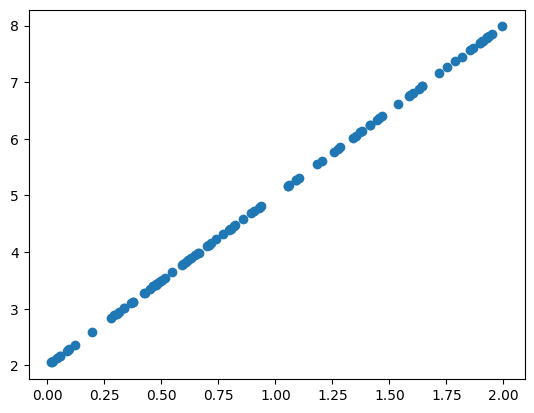

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso, SGDRegressor
from numpy import asarray

# Make data
np.random.seed(67)
n = 100
X = 2 * np.random.rand(n, 1)

y = 2 + 3 * X 

# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Splitting into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=32)

plt.scatter(X,y)

# REGRESSION

# Ridge

### plain GD fixed learning rate to tune

In [8]:
# by hand
def plain_GD(X_train, X_val, y_train, y_val, degree, lmbda):
    np.random.seed(32)
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    epochs = 1000

    for eta in learning_rates:
        
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        for iter in range(epochs):
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train) + 2 * lmbda * beta

            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
            # Update beta
            beta -= eta * gradient
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lmbda = 0.0001
best_model = plain_GD(X_train, X_val, y_train, y_val, 1, lmbda)
best_model[0]

The best model having lambda = 0.0001 used eta = 0.2498777664209341 with validation MSE = 0.0.


array([[2.00039722],
       [2.99939781]])

### with momentum

In [9]:
def plain_GD_with_momentum_OLS(X_train, X_val, y_train, y_val, degree, lmbda, momentum=0.9):
    np.random.seed(32)
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    epochs = 1000

    for eta in learning_rates:
        
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        change = np.zeros_like(beta)  # Initialize change for momentum
        
        for iter in range(epochs):
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train) + 2 * lmbda * beta

            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
            # Update beta using momentum
            new_change = eta * gradient + momentum * change
            beta = beta - new_change
            change = new_change
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model having {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lmbda = 0.0001
best_model = plain_GD_with_momentum_OLS(X_train, X_val, y_train, y_val, 1, lmbda, momentum=0.9)
best_model[0]

The best model having 0.0001 used eta = 0.01 with validation MSE = 0.0.


array([[2.00008427],
       [2.99971104]])

### Adagrad

In [10]:
# Adagrad
def plain_Adagrad(X_train, X_val, y_train, y_val, degree, lmbda):
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    np.random.seed(32)
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    epochs = 1000

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize accumulated squared gradients
        accumulated_gradients = np.zeros_like(beta)

        for iter in range(epochs):
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train) + 2 * lmbda * beta

            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
            # Accumulate squared gradients
            accumulated_gradients += gradient ** 2
            
            # Compute adjusted learning rate
            adjusted_eta = eta / (np.sqrt(accumulated_gradients) + 1e-8)  # Add small value to prevent division by zero
            
            # Update beta
            beta -= adjusted_eta * gradient
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model having {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta


lmbda = 0.0001
best_model = plain_Adagrad(X_train, X_val, y_train, y_val, 1, lmbda)
print("Best model coefficients:", best_model[0])


The best model having 0.0001 used eta = 0.2498777664209341 with validation MSE = 0.0.
Best model coefficients: [[2.00038718]
 [2.99940154]]


In [12]:
# Adagrad con momentum
def plain_Adagrad_momentum(X_train, X_val, y_train, y_val, degree, lmbda, momentum=0.9):
    
    np.random.seed(32)
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    epochs = 1000

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        change = np.zeros_like(beta)
        
        # Initialize accumulated squared gradients
        accumulated_gradients = np.zeros_like(beta)

        for iter in range(epochs):
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train) + 2 * lmbda * beta

            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
                
            # Accumulate squared gradients
            accumulated_gradients += gradient ** 2
            
            # Compute adjusted learning rate
            adjusted_eta = eta / (np.sqrt(accumulated_gradients) + 1e-8)  # Add small value to prevent division by zero
            
            # Update beta using momentum
            new_change = adjusted_eta * gradient + momentum * change
            beta = beta - new_change
            change = new_change
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model having {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lmbda = 0.0001
best_model = plain_Adagrad_momentum(X_train, X_val, y_train, y_val, 1, lmbda)
print("Best model coefficients:", best_model[0])


The best model having 0.0001 used eta = 0.2498777664209341 with validation MSE = 0.0.
Best model coefficients: [[2.00019347]
 [2.99958109]]


### RMSprop

In [15]:
def plain_RMSprop(X_train, X_val, y_train, y_val, degree, lmbda, decay_rate=0.9, epsilon=1e-8):
    np.random.seed(32)
    
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    epochs = 1000

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize accumulated squared gradients for RMSprop
        accumulated_gradients = np.zeros_like(beta)
        
        for iter in range(epochs):
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train) + 2 * lmbda * beta

            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
                
            # Update the accumulated gradients with exponential decay
            accumulated_gradients = decay_rate * accumulated_gradients + (1 - decay_rate) * (gradient ** 2)
            
            # Compute adjusted learning rate using the accumulated gradients
            adjusted_eta = eta / (np.sqrt(accumulated_gradients) + epsilon)
            
            # Update beta using RMSprop rule
            beta -= adjusted_eta * gradient
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lmbda = 0.0001
plain_RMSprop(X_train, X_val, y_train, y_val, 1, lmbda)[0]


The best model having lambda = 0.0001 used eta = 0.1 with validation MSE = 0.0.


array([[2.00030871],
       [2.99947435]])

In [17]:
# momentum
def plain_RMSprop_momentum(X_train, X_val, y_train, y_val, degree, lmbda, decay_rate=0.9, epsilon=1e-8, momentum=0.9):

    np.random.seed(32)
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    epochs = 1000

    for eta in learning_rates:
        
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        change = np.zeros_like(beta)
        
        # Initialize accumulated squared gradients for RMSprop
        accumulated_gradients = np.zeros_like(beta)
        
        for iter in range(epochs):
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train) + 2 * lmbda * beta

            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
                
            # Update the accumulated gradients with exponential decay
            accumulated_gradients = decay_rate * accumulated_gradients + (1 - decay_rate) * (gradient ** 2)
            
            # Compute adjusted learning rate using the accumulated gradients
            adjusted_eta = eta / (np.sqrt(accumulated_gradients) + epsilon)
            
            # Update beta using momentum
            new_change = adjusted_eta * gradient + momentum * change
            beta = beta - new_change
            change = new_change
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta


lmbda = 0.0001
plain_RMSprop_momentum(X_train, X_val, y_train, y_val, 1, lmbda)[0]


The best model having lambda = 0.0001 used eta = 0.01 with validation MSE = 0.0.


array([[2.00008866],
       [2.99963355]])

### ADAM

In [19]:
# Adam implementation with decay rates for moment estimates
def plain_Adam(X_train, X_val, y_train, y_val, degree, lmbda, decay1=0.9, decay2=0.999, epsilon=1e-8):

    np.random.seed(32)
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    epochs = 1000

    for eta in learning_rates:
        
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize first moment vector and second moment vector
        first_moment = np.zeros_like(beta)  # First moment (mean of gradients)
        second_moment = np.zeros_like(beta)  # Second moment (mean of squared gradients)
        time_step = 0  # Time step

        for iter in range(epochs):
            time_step += 1  # Increment the time step
            
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train) + 2 * lmbda * beta

            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
                
            # Update biased first moment estimate
            first_moment = decay1 * first_moment + (1 - decay1) * gradient
            
            # Update biased second raw moment estimate
            second_moment = decay2 * second_moment + (1 - decay2) * (gradient ** 2)
            
            # Correct bias in first moment
            first_moment_corrected = first_moment / (1 - decay1 ** time_step)
            # Correct bias in second moment
            second_moment_corrected = second_moment / (1 - decay2 ** time_step)

            # Update beta
            beta -= eta * first_moment_corrected / (np.sqrt(second_moment_corrected) + epsilon)
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lmbda = 0.0001
plain_Adam(X_train, X_val, y_train, y_val, 1, lmbda)[0]


The best model having lambda = 0.0001 used eta = 0.2498777664209341 with validation MSE = 0.0.


array([[2.00011078],
       [2.99968926]])

## SGD 

In [38]:
# by hand SGD vero
def plain_SGD_hand(X_train, X_val, y_train, y_val, degree, epochs=100, lmbda=0.0001):
    np.random.seed(32)
    
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)

        for epoch in range(epochs):
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            # Iterate through each training example (SGD)
            for x_i, y_i in zip(X_train_poly_shuffled, y_train_shuffled):
                x_i = x_i.reshape(-1, 1) 

                # Calculate the gradient for the single example
                gradient = 2.0 * x_i @ (x_i.T @ beta - y_i) + 2 * lmbda * beta

                # Define a small tolerance for stopping condition
                tolerance = np.full_like(gradient, 0.0001)

                # Check if the gradient is small enough to stop early
                if np.all(np.abs(gradient) <= tolerance):
                    break

                # Update beta
                beta -= eta * gradient

        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)

        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    print("Best Model Coefficients:", best_model)
    return best_model

lmbda = 0.0001
best_model = plain_SGD_hand(X_train, X_val, y_train, y_val, degree=1, epochs=1000, lmbda=lmbda)


The best model used eta = 0.01 with validation MSE = 0.0.
Best Model Coefficients: [[2.00010599]
 [2.99971765]]


In [26]:
# Scikit learn SGD
def plain_SGD(X_train, X_val, y_train, y_val, degree, lmbda):
    best_model_coefficients = None
    best_eta = None
    min_mse_val = float('inf')
    np.random.seed(32)
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train) 
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    epochs = 1000

    for eta in learning_rates:
        # Create the SGDRegressor model 
        sgdreg = SGDRegressor(max_iter=epochs, penalty='l2', alpha=lmbda, eta0=eta, learning_rate='constant', fit_intercept=False)
        sgdreg.fit(X_train_poly, y_train.ravel())
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = sgdreg.predict(X_train_poly)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = sgdreg.predict(X_val_poly)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model coefficients based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            # Concatenate intercept and coefficients into a single array
            best_model_coefficients = sgdreg.coef_
            best_eta = eta

    #print(f"Model coefficients: {best_model_coefficients}")
    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model_coefficients, min_mse_val, best_eta

lmbda = 0.0001
plain_SGD(X_train, X_val, y_train, y_val, 1, lmbda)[0]

The best model having lambda = 0.0001 used eta = 0.2498777664209341 with validation MSE = 0.0.


array([2.00013948, 2.99984557])

## MGD

In [22]:
# by hand
def plain_SGD_with_mini_batches(X_train, X_val, y_train, y_val, degree, lmbda, batch_size=32, epochs=1000):
    best_model = None
    best_eta = None
    min_mse_val = float('inf')

    np.random.seed(32)
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)

        for epoch in range(epochs):
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch) + 2 * lmbda * beta

                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                    
                # Update beta
                beta -= eta * gradient

        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)

        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lmbda = 0.0001
best_model = plain_SGD_with_mini_batches(X_train, X_val, y_train, y_val, 1, lmbda)
print("Best Model Coefficients:", best_model[0])


The best model having lambda = 0.0001 used eta = 0.2498777664209341 with validation MSE = 0.0.
Best Model Coefficients: [[2.00012204]
 [2.99967876]]


### momentum

In [28]:
# SGD batch with momentum
def plain_SGD_with_momentum_Ridge(X_train, X_val, y_train, y_val, degree, lmbda, momentum=0.9, batch_size=32, epochs=100):
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    np.random.seed(32)
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)

        change = np.zeros_like(beta)  # Initialize change for momentum
        
        for epoch in range(epochs):
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch) + 2 * lmbda * beta

                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                # Update beta using momentum
                new_change = eta * gradient + momentum * change
                beta = beta - new_change
                change = new_change
                
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    #print(f"Model coefficients: {best_model_coefficients}")
    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lmbda = 0.0001
best_model = plain_SGD_with_momentum_Ridge(X_train, X_val, y_train, y_val, degree=1, lmbda = lmbda, momentum=0.9, batch_size=16, epochs=1000)
best_model[0]

The best model having lambda = 0.0001 used eta = 0.2498777664209341 with validation MSE = 0.0.


array([[2.0001476 ],
       [2.99966028]])

### minibatch scikit

In [30]:
# Scikit learn minibatch
def plain_SGD_with_batches(X_train, X_val, y_train, y_val, degree, lmbda, batch_size=32, epochs=1000):
    np.random.seed(32)
    best_model_coefficients = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train) 
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        # Initialize SGDRegressor with the specified learning rate
        sgdreg = SGDRegressor(max_iter=1, penalty='l2', alpha=lmbda, eta0=eta, learning_rate='constant', fit_intercept=False)
        
        for epoch in range(epochs):
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            # Iterate over mini-batches
            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]
                
                # Fit the model on the mini-batch
                sgdreg.partial_fit(X_batch, y_batch.ravel())

        # TRAIN - Calculate MSE for training data
        y_hat_train = sgdreg.predict(X_train_poly)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = sgdreg.predict(X_val_poly)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model coefficients based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model_coefficients = sgdreg.coef_
            best_eta = eta

    #print(f"Model coefficients: {best_model_coefficients}")
    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model_coefficients, min_mse_val, best_eta

lmbda = 0.0001
best_model = plain_SGD_with_batches(X_train, X_val, y_train, y_val, degree=1, lmbda=lmbda, batch_size=32, epochs=1000)
best_model[0]

The best model having lambda = 0.0001 used eta = 0.01 with validation MSE = 0.0.


array([2.00010896, 2.99966085])

### Adagrad

In [31]:
# Adagrad no memntum
def SGD_Adagrad(X_train, X_val, y_train, y_val, degree, lmbda, batch_size=32, epochs=1000):
    np.random.seed(32)
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize accumulated squared gradients
        accumulated_gradients = np.zeros_like(beta)

        for epoch in range(epochs):
            
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch) + 2 * lmbda * beta

                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                    
                # Accumulate squared gradients
                accumulated_gradients += gradient ** 2
                
                # Compute adjusted learning rate
                adjusted_eta = eta / (np.sqrt(accumulated_gradients) + 1e-8)  # Add small value to prevent division by zero
                
                # Update beta
                beta -= adjusted_eta * gradient
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    #print(f"Model coefficients: {best_model_coefficients}")
    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lmbda = 0.0001
best_model = SGD_Adagrad(X_train, X_val, y_train, y_val, 1, lmbda)
print("Best model coefficients:", best_model[0])


The best model having lambda = 0.0001 used eta = 0.1 with validation MSE = 0.0.
Best model coefficients: [[2.00112959]
 [2.99870724]]


In [32]:
# Adagrad momentum  
def SGD_Adagrad_momentum(X_train, X_val, y_train, y_val, degree, lmbda, batch_size=32, epochs=1000, momentum=0.9):
    np.random.seed(32)
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize accumulated squared gradients
        accumulated_gradients = np.zeros_like(beta)

        # Initialize change for momentum
        change = np.zeros_like(beta)  

        for epoch in range(epochs):
            
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch) + 2 * lmbda * beta

                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                    
                # Accumulate squared gradients
                accumulated_gradients += gradient ** 2
                
                # Compute adjusted learning rate
                adjusted_eta = eta / (np.sqrt(accumulated_gradients) + 1e-8)  # Add small value to prevent division by zero
                
                # Update beta using momentum
                new_change = adjusted_eta * gradient + momentum * change
                beta = beta - new_change
                change = new_change
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    #print(f"Model coefficients: {best_model_coefficients}")
    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lmbda = 0.0001
best_model = SGD_Adagrad_momentum(X_train, X_val, y_train, y_val, 1, lmbda)
print("Best model coefficients:", best_model[0])


The best model having lambda = 0.0001 used eta = 0.1 with validation MSE = 0.0.
Best model coefficients: [[2.00011517]
 [2.9996565 ]]


### RMSprop


In [33]:
# no memntum
def SGD_RMSprop(X_train, X_val, y_train, y_val, degree, lmbda, batch_size=32, epochs=1000, decay_rate=0.9):
    np.random.seed(32)
    
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize accumulated squared gradients
        accumulated_gradients = np.zeros_like(beta)

        for epoch in range(epochs):
            
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch) + 2 * lmbda * beta

                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                    
                # Accumulate squared gradients
                accumulated_gradients =  decay_rate * accumulated_gradients + (1 - decay_rate) * (gradient ** 2)
                
                # Compute adjusted learning rate
                adjusted_eta = eta / (np.sqrt(accumulated_gradients) + 1e-8)  # Add small value to prevent division by zero
                
                # Update beta
                beta -= adjusted_eta * gradient
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    #print(f"Model coefficients: {best_model_coefficients}")
    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lmbda = 0.0001
best_model = SGD_RMSprop(X_train, X_val, y_train, y_val, 1, lmbda)
print("Best model coefficients:", best_model[0])


The best model having lambda = 0.0001 used eta = 0.01 with validation MSE = 0.0001.
Best model coefficients: [[1.99357078]
 [2.99716004]]


In [34]:
# momentum
def SGD_RMSprop_momentum(X_train, X_val, y_train, y_val, degree, lmbda, batch_size=32, epochs=100, decay_rate=0.9, momentum=0.9):
    np.random.seed(32)
    
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize accumulated squared gradients
        accumulated_gradients = np.zeros_like(beta)

        # Initialize change for momentum
        change = np.zeros_like(beta)  

        for epoch in range(epochs):
            
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch) + 2 * lmbda * beta

                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                    
                # Accumulate squared gradients
                accumulated_gradients =  decay_rate * accumulated_gradients + (1 - decay_rate) * (gradient ** 2)
                
                # Compute adjusted learning rate
                adjusted_eta = eta / (np.sqrt(accumulated_gradients) + 1e-8)  # Add small value to prevent division by zero
                
                # Update beta using momentum
                new_change = adjusted_eta * gradient + momentum * change
                beta = beta - new_change
                change = new_change
                
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    #print(f"Model coefficients: {best_model_coefficients}")
    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lmbda = 0.0001
best_model = SGD_RMSprop_momentum(X_train, X_val, y_train, y_val, 1, lmbda)
print("Best model coefficients:", best_model[0])


The best model having lambda = 0.0001 used eta = 0.01 with validation MSE = 0.0.
Best model coefficients: [[1.99163145]
 [3.00328533]]


### ADAM

In [35]:
# by hand
def SGD_ADAM(X_train, X_val, y_train, y_val, degree, lmbda, batch_size=32, epochs=1000, decay1=0.9, decay2=0.999, epsilon=1e-8):
    np.random.seed(32)
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)
    
    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    
    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)

        # Initialize first moment vector and second moment vector
        first_moment = np.zeros_like(beta)  # First moment (mean of gradients)
        second_moment = np.zeros_like(beta)  # Second moment (mean of squared gradients)
        time_step = 0  # Time step

        for epoch in range(epochs):
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                time_step += 1
                
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch) + 2 * lmbda * beta

                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                    
                # Update biased first moment estimate
                first_moment = decay1 * first_moment + (1 - decay1) * gradient
                
                # Update biased second raw moment estimate
                second_moment = decay2 * second_moment + (1 - decay2) * (gradient ** 2)
                
                # Correct bias in first moment
                first_moment_corrected = first_moment / (1 - decay1 ** time_step)
                # Correct bias in second moment
                second_moment_corrected = second_moment / (1 - decay2 ** time_step)
    
                # Update beta
                beta -= eta * first_moment_corrected / (np.sqrt(second_moment_corrected) + epsilon)
            
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)

        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    #print(f"Model coefficients: {best_model_coefficients}")
    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lmbda = 0.0001
best_model = SGD_ADAM(X_train, X_val, y_train, y_val, degree=1, lmbda=lmbda, batch_size=32, epochs=1000)
print("Best Model Coefficients:", best_model[0])


The best model having lambda = 0.0001 used eta = 0.2498777664209341 with validation MSE = 0.0.
Best Model Coefficients: [[2.0000999 ]
 [2.99966591]]
